In [6]:
import math

c_dict = {
    4: 32, #8,
    6: 12, #3
}

cidr_max = {
    4: 28,
    6: 48
}

def __get_min_samples(ip_version, mask):

    c= c_dict[ip_version]

    
    if ip_version == 4:
        ipv_max = 32
        min_samples=int(c * math.sqrt( math.pow(2, (ipv_max - mask))))
    elif ip_version == 6:
        ipv_max = 64
        min_samples=int(c * math.sqrt(math.sqrt( math.pow(2, (ipv_max - mask)))))
    else:
        pass

    # TODO für später
    

    # bei v6 doppelte wurzel

    # self.logger.info(f"min samples: {min_samples}")
    return min_samples

for i in range(0, cidr_max[4]):
    print(f"4 {i}:\t{__get_min_samples(4,i)}")

for i in range(0, cidr_max[6]):
    print(f"6 {i}:\t{__get_min_samples(6,i)}")

4 0:	4194304
4 1:	2965820
4 2:	2097152
4 3:	1482910
4 4:	1048576
4 5:	741455
4 6:	524288
4 7:	370727
4 8:	262144
4 9:	185363
4 10:	131072
4 11:	92681
4 12:	65536
4 13:	46340
4 14:	32768
4 15:	23170
4 16:	16384
4 17:	11585
4 18:	8192
4 19:	5792
4 20:	4096
4 21:	2896
4 22:	2048
4 23:	1448
4 24:	1024
4 25:	724
4 26:	512
4 27:	362
6 0:	2457600
6 1:	2066587
6 2:	1737785
6 3:	1461297
6 4:	1228800
6 5:	1033293
6 6:	868892
6 7:	730648
6 8:	614400
6 9:	516646
6 10:	434446
6 11:	365324
6 12:	307200
6 13:	258323
6 14:	217223
6 15:	182662
6 16:	153600
6 17:	129161
6 18:	108611
6 19:	91331
6 20:	76800
6 21:	64580
6 22:	54305
6 23:	45665
6 24:	38400
6 25:	32290
6 26:	27152
6 27:	22832
6 28:	19200
6 29:	16145
6 30:	13576
6 31:	11416
6 32:	9600
6 33:	8072
6 34:	6788
6 35:	5708
6 36:	4800
6 37:	4036
6 38:	3394
6 39:	2854
6 40:	2400
6 41:	2018
6 42:	1697
6 43:	1427
6 44:	1200
6 45:	1009
6 46:	848
6 47:	713


In [ ]:
from netaddr import IPNetwork, IPAddress
import pytricia
from collections import defaultdict

def join_siblings(ip_version, mask, prange):

    ## check if join would be possible
    if mask == 0:
        print("        join siblings not possible - we are at the root of the tree")
        return None


    nw = IPNetwork(f"{prange}/{mask}")


    #### GET SUPERNET
    nw_supernet=nw.supernet(mask-1)[0]
    supernet_ip=str(nw_supernet).split("/")[0]
    supernet_mask=int(str(nw_supernet).split("/")[1])

    siblings=list(nw_supernet.subnet(mask))
    print(f"join_siblings supernet: {nw_supernet}")
    print(f" siblings: {siblings}")

join_siblings(6,48,"2a05:d018:1::" )

p = pytricia.PyTricia(48)
p.insert("0:0:2::/48","0:0:2::/48",)
p.insert("2a05:d018::/48", "2a05:d018::/48")
p.insert("2a05:d018:8000::/48", "2a05:d018:8000::/48")
p.insert("2a05:d018:1::/48", "2a05:d018:1::/48")


print("lpm: ", list(p))

for i in ["2a05:d018:1::", "2a05:d018:dc0::", "2a05:d018:76c::", "2a05:d018:5::", "2a05:d018:4e8::"]:
    try:
        print(p[i])
    except:
        print(f"prefix not found: {i}")


d = defaultdict(int)
d["0:0:2::/48"] = 5

print(d)
d.pop("0:0:2::/48",)


In [ ]:
from clickhouse_driver import Client

cl = Client('localhost')

query='''
select
    netid_string1,
    --has_smaller_as,
    --has_bigger_as,
    --origins_net1_in_net2,
    --origins_net2_in_net1,
    1
from (
        select
            netid_string1,
            (
                select
                    tuple (
                        groupArray(substring(netid_string, 8)), --ipv4 only.
                        groupArray(mask),
                        groupArray(origin)
                    )
                from
                    ipd.prefix_as__v
                where
                    origin > 0
                    and netid_string <> '::ffff:0.0.0.0'
            ) as prefixdata,
            -- prefixdata.1,
            -- prefixdata.2,
            -- prefixdata.3,
            -- arrayMap(
            --     (netid_string2, mask2) -> isIPAddressInRange(netid_string1, concat(netid_string2, '/', toString(mask2))),
            --     prefixdata.1,
            --     prefixdata.2
            -- ) as mask_net1_in_net2,
            -- arrayMap(
            --     (netid_string2, mask2) -> isIPAddressInRange(netid_string2, concat(netid_string1, '/', toString(mask1))),
            --     prefixdata.1,
            --     prefixdata.2
            -- ) as mask_net2_in_net1,
            -- arrayReduce('sum', mask_net2_in_net1) as has_smaller_as,
            -- arrayReduce('sum', mask_net1_in_net2) as has_bigger_as,
            arrayFilter(
                (_, y) -> y,
                prefixdata.3,
                arrayMap(
                    (netid_string2, mask2) -> isIPAddressInRange(netid_string1, concat(netid_string2, '/', toString(mask2))),
                    prefixdata.1,
                    prefixdata.2
                )
            ) as origins_net1_in_net2,
            arrayFilter(
                (_, y) -> y,
                prefixdata.3,
                arrayMap(
                    (netid_string2, mask2) -> isIPAddressInRange(netid_string2, concat(netid_string1, '/', toString(mask1))),
                    prefixdata.1,
                    prefixdata.2
                )
            ) as origins_net2_in_net1,
            1
        from (
            select
                t as T1,
                netid_string as netid_string1,
                mask as mask1
            from
                ipd.range__time_subnet_ingress__v
            where
                ip_version = 4
                and t = toDateTime('2020-09-08 21:00:00')
                -- and metroHash64(netid_string1) % 8 = 0
            order by
                netid_num
            -- limit 1
        ) as X1
        where
            1
            -- and has_smaller_as + has_bigger_as > 0
            and length(origins_net1_in_net2) + length(origins_net2_in_net1) > 0

)
limit 100
'''

#cl.execute(query)

currently 59.09 % done (887.0 minutes)

IPD run: avg: 76.5140924464487s; min: 0; max: 167
iteration run: avg: 178.9977452085682s; min: 3s; max: 327s


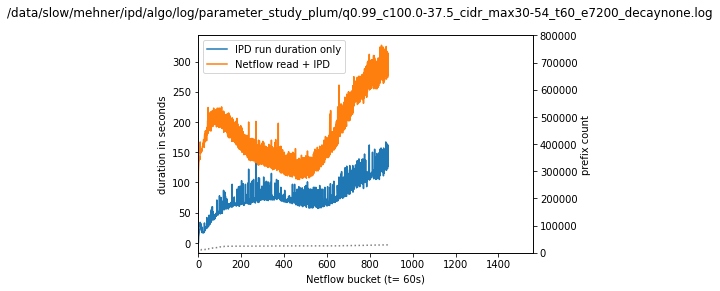

currently 46.57 % done (699.0 minutes)

IPD run: avg: 724.9141630901288s; min: 0; max: 1724
iteration run: avg: 818.8583690987125s; min: 3s; max: 1776s


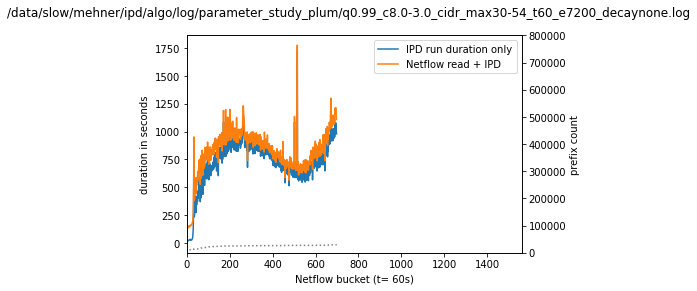

currently 46.64 % done (700.0 minutes)

IPD run: avg: 748.3s; min: 0; max: 1644
iteration run: avg: 840.7728571428571s; min: 4s; max: 1698s


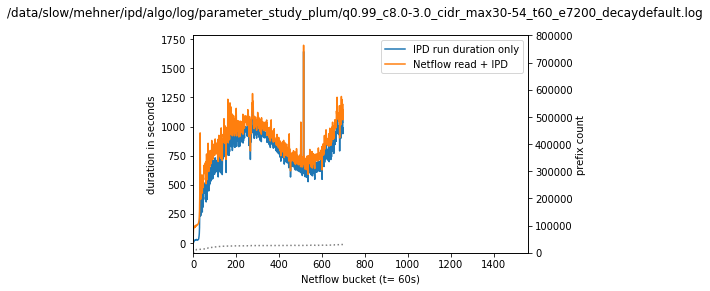

currently 74.15 % done (1113.0 minutes)

IPD run: avg: 96.21723518850987s; min: 0; max: 234
iteration run: avg: 213.17969451931717s; min: 4s; max: 397s


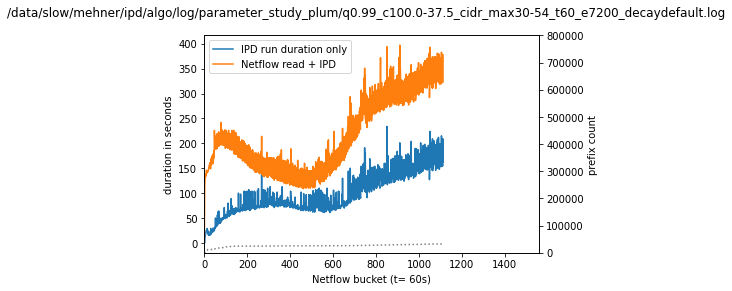

currently 65.29 % done (980.0 minutes)

IPD run: avg: 746.9887869520898s; min: 0; max: 1684
iteration run: avg: 859.4928571428571s; min: 4s; max: 1842s


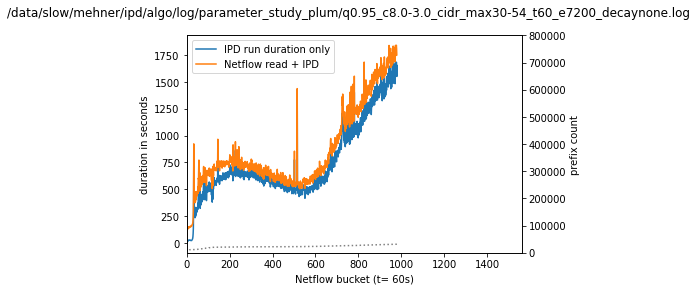

currently 65.82 % done (988.0 minutes)

IPD run: avg: 742.6983805668016s; min: 0; max: 1687
iteration run: avg: 853.0941295546559s; min: 4s; max: 1868s


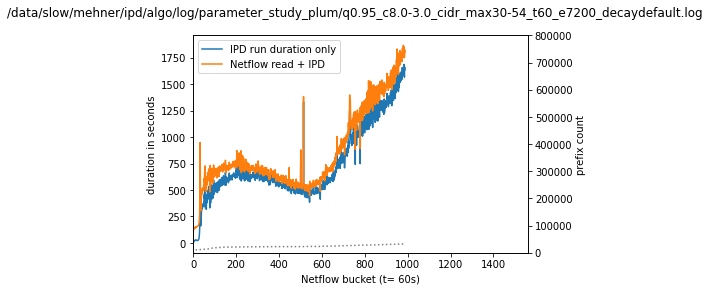

currently 72.55 % done (1089.0 minutes)

IPD run: avg: 436.5151515151515s; min: 0; max: 1051
iteration run: avg: 547.5390266299357s; min: 4s; max: 1224s


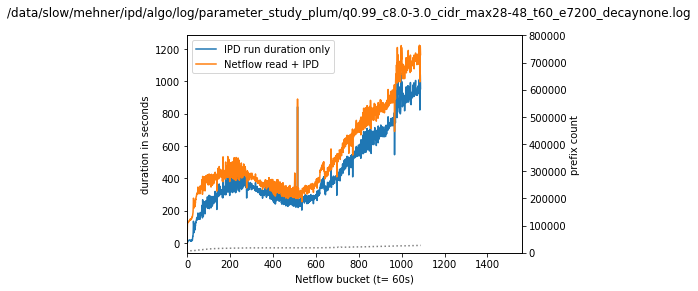

currently 78.01 % done (1171.0 minutes)

IPD run: avg: 494.0964163822526s; min: 0; max: 1228
iteration run: avg: 609.4158838599487s; min: 3s; max: 1384s


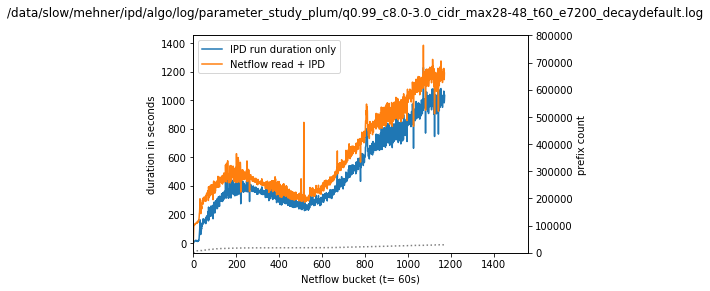

currently 95.74 % done (1437.0 minutes)

IPD run: avg: 159.9714683368128s; min: 0; max: 322
iteration run: avg: 299.78775226165624s; min: 4s; max: 557s


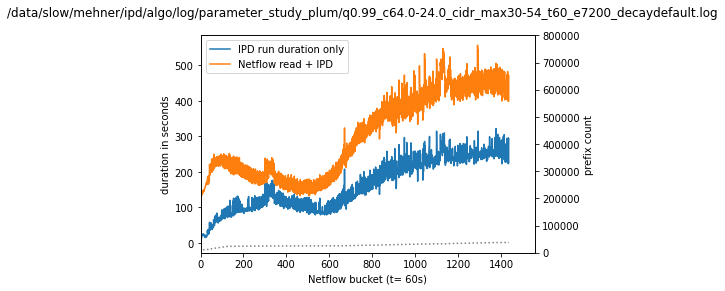

currently 98.40 % done (1477.0 minutes)

IPD run: avg: 151.552471225457s; min: 0; max: 318
iteration run: avg: 287.8896411645227s; min: 4s; max: 546s


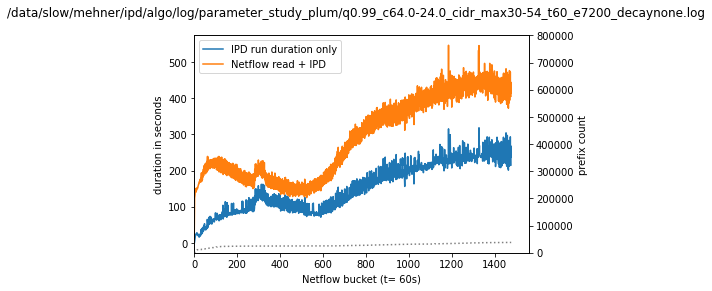

currently 96.54 % done (1449.0 minutes)

IPD run: avg: 449.03657694962044s; min: 0; max: 944
iteration run: avg: 581.8757763975156s; min: 4s; max: 1178s


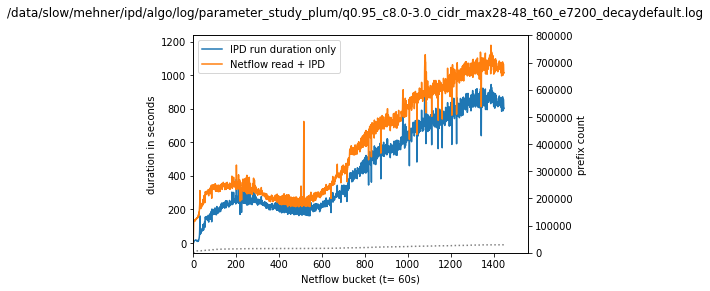

DONE: 2 runs


In [1]:
import datetime
from sys import prefix
import matplotlib.pyplot as plt
import glob
import numpy as np
import socket
hostname = socket.gethostname()

logfile_path = {
    'bithouse': "/data/slow/mehner/ipd/algo/log/parameter_study_plum",
    'manni': "/home/stefan/WORK/ipd/algo/log/parameter_study",
    'plum': "/home/mehneste/WORK/ipd/algo/log/parameter_study"}


# data stuff

format = "%Y-%m-%d %H:%M:%S,%f"

done_counter = 0

#for logfile in glob.glob(f"{logfile_path.get(hostname)}/*"):
for i in ['q0.99_c100.0-37.5_cidr_max30-54_t60_e7200_decaynone.log',
          'q0.99_c8.0-3.0_cidr_max30-54_t60_e7200_decaynone.log',
          'q0.99_c8.0-3.0_cidr_max30-54_t60_e7200_decaydefault.log',
          'q0.99_c100.0-37.5_cidr_max30-54_t60_e7200_decaydefault.log',
          'q0.95_c8.0-3.0_cidr_max30-54_t60_e7200_decaynone.log',
          'q0.95_c8.0-3.0_cidr_max30-54_t60_e7200_decaydefault.log',
          'q0.99_c8.0-3.0_cidr_max28-48_t60_e7200_decaynone.log',
          'q0.99_c8.0-3.0_cidr_max28-48_t60_e7200_decaydefault.log',
          'q0.99_c64.0-24.0_cidr_max30-54_t60_e7200_decaydefault.log',
          'q0.99_c100.0-37.5_cidr_max28-48_t60_e7200_decaynone.log',
          'q0.99_c64.0-24.0_cidr_max30-54_t60_e7200_decaynone.log',
          'q0.95_c8.0-3.0_cidr_max28-48_t60_e7200_decaydefault.log',
          'q0.95_c8.0-3.0_cidr_max28-48_t60_e7200_decaynone.log',
          ]:
    
    logfile=f"{logfile_path.get(hostname)}/{i}"
    try:
        file = open(logfile, 'r')
        Lines = file.readlines()

        count = 0
        last_start_ts = None
        start_ts = None
        end_ts = None

        ipd_run_list = []
        iteration_run_list = []
        prefix_list = []
        for line in Lines:
            count += 1
            # print("Line{}: {}".format(count, line.strip()))
            x = line.split(" ")

            ts = datetime.datetime.strptime(f"{x[0]} {x[1]}", format)
            # print(ts)
            if last_start_ts == None:
                last_start_ts = ts
            if "run IPD" in line:
                start_ts = ts
                try:
                    prefix_list.append(int(x[-2]))
                except:
                    pass

                if last_start_ts != start_ts:
                    iteration_duration = start_ts - last_start_ts
                    if int(iteration_duration.seconds) > 600:
                        # print(x)
                        #print(f"Caution: {last_start_ts} -> {start_ts}: netflow ts: {int(x[-5])} iteration run took extremly long: {iteration_duration}")
                        pass
                    iteration_run_list.append(iteration_duration.seconds)
                    last_start_ts = start_ts

            elif "Finished" in line:
                end_ts = ts
                duration = end_ts - start_ts
                ipd_run_list.append(duration.seconds)

        # plotting stuff
        # get t
        t = int(logfile.split("_t")[1].split("_e")[0])

        if len(iteration_run_list)*t/60 >= 1495:
            done_counter += 1
        
        else:
            fig, ax = plt.subplots()
            ax.plot(ipd_run_list, label="IPD run duration only")
            ax.plot(iteration_run_list, label="Netflow read + IPD")
            # ax.set_xticklabels(np.arange(0, 1560, t))

            ax.set_xlabel(f"Netflow bucket (t= {int(t)}s)")
            ax.set_ylabel("duration in seconds")
            # ax.set_ylim(0, 500)

            ax.set_xlim(0, int(1560/(t/60)))

            plt.legend()

            ax2 = ax.twinx()
            ax2.plot(prefix_list, label="prefix count", linestyle="dotted", color="grey")
            ax2.set_ylabel("prefix count")
            ax2.set_ylim(0, 800000)

            plt.suptitle(f"{logfile}")

            print(f"currently {(len(iteration_run_list)*t/60/1501)*100:.2f} % done ({len(iteration_run_list)*t/60} minutes)")
            print(f"")
            print(f"IPD run: avg: {sum(ipd_run_list) / len(ipd_run_list)}s; min: {min(ipd_run_list)}; max: {max(ipd_run_list)}")
            print(f"iteration run: avg: {sum(iteration_run_list) / len(iteration_run_list)}s; min: {min(iteration_run_list)}s; max: {max(iteration_run_list)}s")
            plt.show()
    except:
        pass


print(f"DONE: {done_counter} runs")
